In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime

# Functions

Chromosome evaluation functions

In [0]:
def count_collisions(m):
    queen_pose = np.argwhere(m > 0)
    total_collision = 0
    for queen_y, queen_x in queen_pose:

        current_queen_collision = 0
        for d in range(1, m.shape[0]):
            for x_dir in [+1, 0, -1]:
                x_check = x_dir * d + queen_x
                if x_check < 0 or x_check >= m.shape[0]:
                    continue

                for y_dir in [+1, 0, -1]:
                    y_check = y_dir * d + queen_y
                    if y_dir == 0 and x_dir == 0:
                        continue
                    if y_check < 0 or y_check >= m.shape[0]:
                        continue

                    cell_value = m[y_check, x_check]
                    current_queen_collision += cell_value

        total_collision += current_queen_collision

    return int(total_collision)


def chromosome_to_board(c):
    board_size = c.shape[0]
    m = np.zeros([board_size, board_size])
    for yt, xt in enumerate(c):
        m[yt, int(xt)] = 1
    return m


def generate_random_chromosome(board_size=8):
    c = np.random.randint(0, board_size, board_size)
    return c


def fitness_function(c):
    m = chromosome_to_board(c)
    collisions = float(count_collisions(m))
    return collisions

chromosome mating functions

In [0]:
def uniform_mate(c1, c2, mutation_rate=None, crossover_rate=None):
    chromosome_size = c1.shape[0]

    if mutation_rate is None:
        mutation_rate = 1.0 / float(chromosome_size)
    if crossover_rate is None:
        crossover_rate = 1.0 / float(chromosome_size)

    cx = c1.copy()
    cy = c2.copy()

    do_crossover = np.random.random() <= crossover_rate
    if do_crossover:
        for posx in range(chromosome_size):
            # Uniform mate cx chromosome
            pick_second_parent_cx = np.random.choice([True, False])
            if pick_second_parent_cx:
                cx[posx] = c2[posx]
            else:
                pass
            
            # Uniform mate cy chromosome
            pick_second_parent_cy = np.random.choice([True, False])
            if pick_second_parent_cy:
                cy[posx] = c1[posx]
            else:
                pass

    for posx in range(chromosome_size):
        # Mutate cx.
        do_mutation_cx = np.random.random() <= mutation_rate
        if do_mutation_cx:
            cx[posx] = np.random.randint(chromosome_size)

        # Mutate cx.
        do_mutation_cy = np.random.random() <= mutation_rate
        if do_mutation_cy:
            cy[posx] = np.random.randint(chromosome_size)

    return cx, cy

# Evolution loop

constants and hyperparameters

In [0]:
board_size = 8
mutation_rate = 0.1
crossover_rate = 0.8
number_of_generations = 10000
population_size = 100
extinction = 50
elitism = 2

In [0]:
population = list()
statistics_df = pd.DataFrame(index=range(number_of_generations), columns=range(population_size))
top_runner = pd.DataFrame(index=range(number_of_generations), columns=range(board_size))

for chromosome_idx in range(population_size):
    c = generate_random_chromosome()
    population.append(c)

In [0]:
# Each Row is a chromosome in "population"
start_time = datetime.now()
population = np.array(population)
for gen_idx in range(number_of_generations):
    scores = np.apply_along_axis(fitness_function, 1, population)
    population_with_scores = np.column_stack((population, scores))
    population_with_scores = population_with_scores[population_with_scores[:, -1].argsort()]

    # Gather statistics
    statistics_df.loc[gen_idx] = scores
    top_runner.loc[gen_idx] = population_with_scores[0, :-1]
    runtime = datetime.now() - start_time
    print(f"[{runtime}][Gen: {gen_idx + 1:>3} / {number_of_generations}]\tAverage: {scores.mean()}\tstd: {scores.std():>.3f}\tBest: {scores.min()}")
    if scores.min() == 0:
        print("Problem solved. breaking")
        statistics_df = statistics_df.dropna(axis=0)
        top_runner = top_runner.dropna(axis=0)
        break

    # Normalize scores
    max_collisions = 56.0
    population_with_scores[:, -1] = 1 - (population_with_scores[:, -1] / max_collisions)

    # repopulate after killing chromosomes
    offsprings_to_generate = population_size
    offsprings = np.zeros([offsprings_to_generate, population_with_scores.shape[1]])

    # Apply elitism
    offsprings[:elitism] = population_with_scores[:elitism]

    # Apply extinction
    if extinction > 0:
      population_with_scores = population_with_scores[:-extinction]
      population_with_scores[:, -1] = population_with_scores[:, -1] / population_with_scores[:, -1].sum()

    for offspring_idx in range(elitism, offsprings_to_generate, 2):
        p = population_with_scores[:, -1]
        parents_idxes = list(range(len(p)))
        parents_idx = np.random.choice(parents_idxes, size=2, p=p, replace=False)
        p1, p2 = population_with_scores[parents_idx, :-1]
        cx, cy = uniform_mate(p1, p2, mutation_rate=mutation_rate, crossover_rate=crossover_rate)

        cx = np.append(cx, [0])  # Added score to match shape
        cy = np.append(cy, [0])  # Added score to match shape

        offsprings[offspring_idx] = cx
        offsprings[offspring_idx + 1] = cy

    # Join offsprings to general population
    population = offsprings
    population = population[:, :-1]

[0:00:00.058856][Gen:   1 / 10000]	Average: 15.76	std: 4.641	Best: 4.0
[0:00:00.121481][Gen:   2 / 10000]	Average: 14.28	std: 4.409	Best: 4.0
[0:00:00.181711][Gen:   3 / 10000]	Average: 13.02	std: 4.238	Best: 4.0
[0:00:00.247161][Gen:   4 / 10000]	Average: 11.98	std: 3.693	Best: 4.0
[0:00:00.321413][Gen:   5 / 10000]	Average: 11.46	std: 4.194	Best: 4.0
[0:00:00.383580][Gen:   6 / 10000]	Average: 11.16	std: 3.818	Best: 4.0
[0:00:00.449073][Gen:   7 / 10000]	Average: 11.26	std: 3.864	Best: 4.0
[0:00:00.513173][Gen:   8 / 10000]	Average: 11.08	std: 3.725	Best: 4.0
[0:00:00.580863][Gen:   9 / 10000]	Average: 11.18	std: 3.941	Best: 4.0
[0:00:00.641667][Gen:  10 / 10000]	Average: 11.5	std: 3.735	Best: 4.0
[0:00:00.709560][Gen:  11 / 10000]	Average: 11.34	std: 3.465	Best: 4.0
[0:00:00.772214][Gen:  12 / 10000]	Average: 10.8	std: 3.899	Best: 4.0
[0:00:00.837089][Gen:  13 / 10000]	Average: 10.74	std: 3.956	Best: 2.0
[0:00:00.897395][Gen:  14 / 10000]	Average: 10.36	std: 4.218	Best: 2.0
[0:00:00

# Results analysis

best and average score of each generation

[]

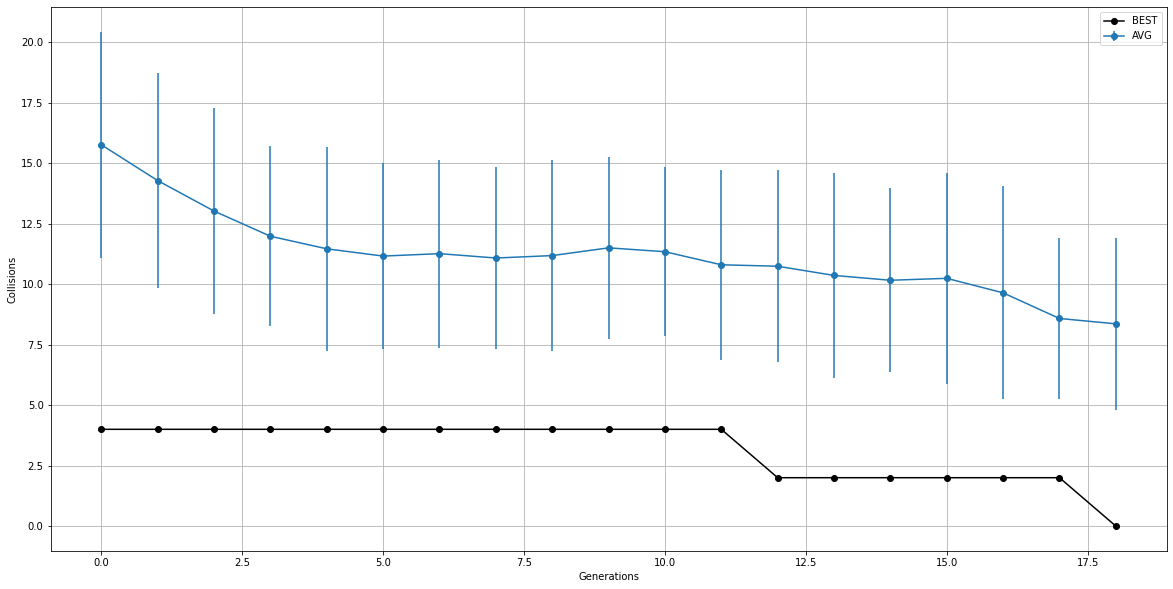

In [0]:
std = statistics_df.std(axis=1)
avg = statistics_df.mean(axis=1)
best = statistics_df.min(axis=1)

# plt.plot(avg,label='AVG')
plt.figure(figsize=(20,10))
plt.errorbar(avg.index, avg, yerr=std, fmt='-o',label='AVG')
plt.plot(best,'-o',label='BEST',  color='black')
plt.grid()
plt.legend()
plt.xlabel('Generations')
plt.ylabel('Collisions')
plt.plot()

Visualization of the winner

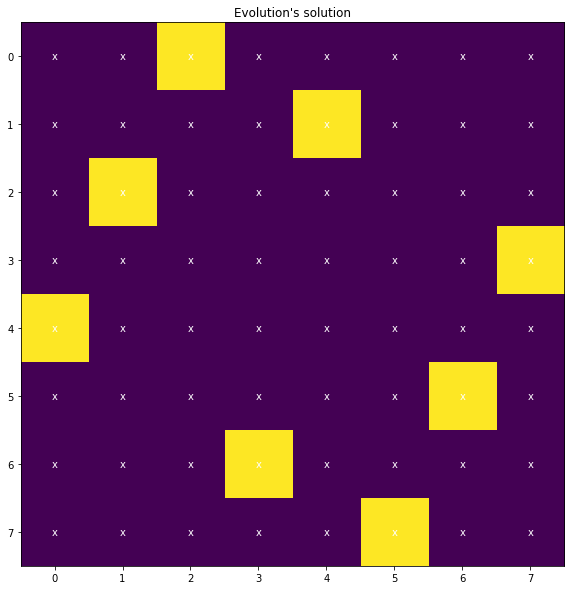

In [0]:
m = chromosome_to_board(top_runner.iloc[-1])

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Evolution's solution")
ax.imshow(m)
ax.set_xticks(np.arange(m.shape[0]))
ax.set_yticks(np.arange(m.shape[1]))
for i in range(m.shape[0]):
    for j in range(m.shape[0]):
        text = ax.text(j, i, 'x',
                       ha="center", va="center", color="w")

# Brute force

Brute force with skipping queens in the same row

In [0]:
import itertools

best = 9999999
start_time = datetime.now()
seed_data = [0,1,2,3,4,5,6,7]
np.random.shuffle(seed_data)
for c_idx,c_array in enumerate(itertools.permutations(seed_data)):
  c = pd.Series(index=range(8),data=c_array)
  score = fitness_function(c)
  best = min(best, score)
  runtime = datetime.now() - start_time
  print(f"[{runtime}][{c_idx:>4}] \t {c_array}\t Score: {score}\t Best: {best}")

  if score == 0:
    print("Problem solved. breaking")
    break

[0:00:00.001461][   0] 	 (0, 5, 7, 3, 2, 6, 1, 4)	 Score: 10.0	 Best: 10.0
[0:00:00.002612][   1] 	 (0, 5, 7, 3, 2, 6, 4, 1)	 Score: 10.0	 Best: 10.0
[0:00:00.003490][   2] 	 (0, 5, 7, 3, 2, 1, 6, 4)	 Score: 18.0	 Best: 10.0
[0:00:00.004258][   3] 	 (0, 5, 7, 3, 2, 1, 4, 6)	 Score: 16.0	 Best: 10.0
[0:00:00.005036][   4] 	 (0, 5, 7, 3, 2, 4, 6, 1)	 Score: 14.0	 Best: 10.0
[0:00:00.006186][   5] 	 (0, 5, 7, 3, 2, 4, 1, 6)	 Score: 12.0	 Best: 10.0
[0:00:00.006992][   6] 	 (0, 5, 7, 3, 6, 2, 1, 4)	 Score: 8.0	 Best: 8.0
[0:00:00.007772][   7] 	 (0, 5, 7, 3, 6, 2, 4, 1)	 Score: 6.0	 Best: 6.0
[0:00:00.008523][   8] 	 (0, 5, 7, 3, 6, 1, 2, 4)	 Score: 10.0	 Best: 6.0
[0:00:00.009266][   9] 	 (0, 5, 7, 3, 6, 1, 4, 2)	 Score: 12.0	 Best: 6.0
[0:00:00.010005][  10] 	 (0, 5, 7, 3, 6, 4, 2, 1)	 Score: 8.0	 Best: 6.0
[0:00:00.010766][  11] 	 (0, 5, 7, 3, 6, 4, 1, 2)	 Score: 12.0	 Best: 6.0
[0:00:00.011519][  12] 	 (0, 5, 7, 3, 1, 2, 6, 4)	 Score: 14.0	 Best: 6.0
[0:00:00.012261][  13] 	 (0, 5, 7, 

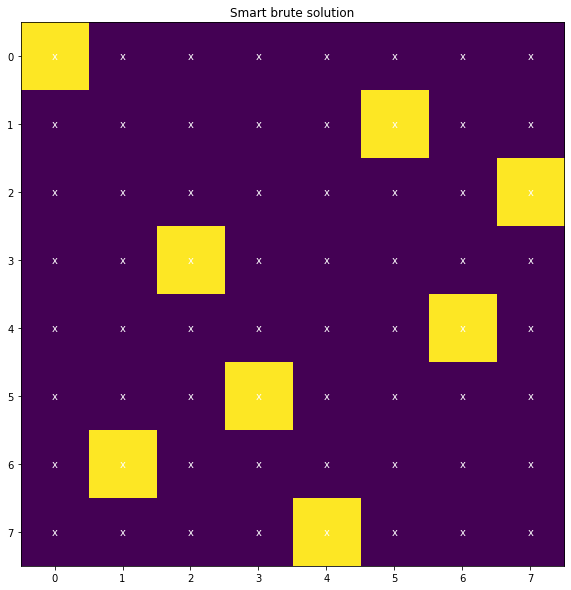

In [0]:
m = chromosome_to_board(c)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Smart brute solution")
ax.imshow(m)
ax.set_xticks(np.arange(m.shape[0]))
ax.set_yticks(np.arange(m.shape[1]))
for i in range(m.shape[0]):
    for j in range(m.shape[0]):
        text = ax.text(j, i, 'x',
                       ha="center", va="center", color="w")

Brute force without skipping queens in the same row

In [0]:
def get_next_chromosome_linear(c):
  cx = c.astype(int)
  cx[0] += 1
  while cx.max() >= 8:
    c_div, c_mod = cx.divmod(8)
    c_div = c_div.shift(1,fill_value=0)
    cx = c_mod + c_div
  return cx

def get_next_chromosome_random(c):
  cx = c = pd.Series(data=np.random.randint(8, size=8),index=range(8))
  return cx

start_time = datetime.now()
best = 999999999
c = pd.Series(data=0,index=range(8))
for c_idx in range(9999999999999999):
  c_array = c.values
  score = fitness_function(c)
  best = min(score,best)
  runtime = datetime.now() - start_time
  print(f"[{runtime}][{c_idx:>4}] \t {c_array}\t Score: {score}\t Best: {best}")

  if score == 0:
    print("Problem solved. breaking")
    break
  c = get_next_chromosome_random(c)


Streaming output truncated to the last 5000 lines.
[0:03:31.328601][203693] 	 [1 5 1 5 2 0 6 1]	 Score: 12.0	 Best: 2.0
[0:03:31.329469][203694] 	 [5 1 6 6 5 2 0 0]	 Score: 10.0	 Best: 2.0
[0:03:31.330340][203695] 	 [1 2 6 6 6 6 4 4]	 Score: 24.0	 Best: 2.0
[0:03:31.331196][203696] 	 [1 7 4 0 4 4 6 1]	 Score: 16.0	 Best: 2.0
[0:03:31.332057][203697] 	 [5 6 2 3 0 3 2 4]	 Score: 14.0	 Best: 2.0
[0:03:31.332927][203698] 	 [0 0 7 0 2 6 0 7]	 Score: 18.0	 Best: 2.0
[0:03:31.333816][203699] 	 [2 4 2 3 1 4 2 4]	 Score: 18.0	 Best: 2.0
[0:03:31.334707][203700] 	 [6 3 3 1 4 6 2 1]	 Score: 16.0	 Best: 2.0
[0:03:31.335565][203701] 	 [6 5 2 6 6 3 4 4]	 Score: 14.0	 Best: 2.0
[0:03:31.336474][203702] 	 [6 2 0 3 1 0 5 3]	 Score: 8.0	 Best: 2.0
[0:03:31.337353][203703] 	 [2 0 5 7 4 0 4 0]	 Score: 12.0	 Best: 2.0
[0:03:31.338248][203704] 	 [5 2 3 1 4 2 6 2]	 Score: 12.0	 Best: 2.0
[0:03:31.339141][203705] 	 [1 0 3 4 2 7 1 4]	 Score: 14.0	 Best: 2.0
[0:03:31.340024][203706] 	 [3 7 3 0 4 4 0 4]	 Score: 

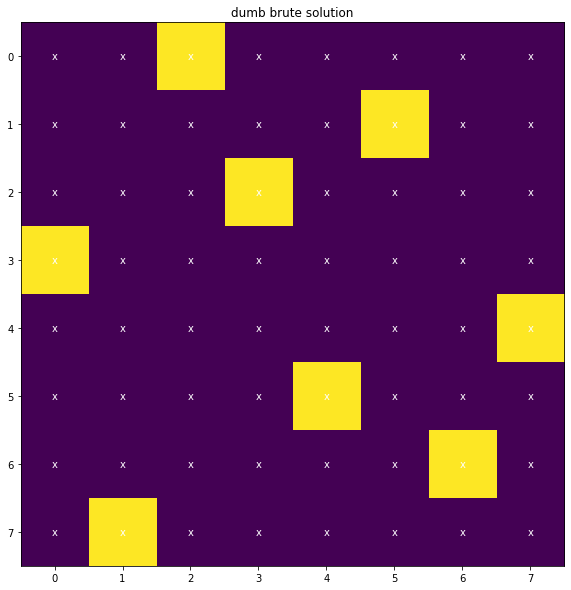

In [0]:
m = chromosome_to_board(c)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("dumb brute solution")
ax.imshow(m)
ax.set_xticks(np.arange(m.shape[0]))
ax.set_yticks(np.arange(m.shape[1]))
for i in range(m.shape[0]):
    for j in range(m.shape[0]):
        text = ax.text(j, i, 'x',
                       ha="center", va="center", color="w")